##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "white", font="verdana") # font_scale = 1.35)

##### Pandas Display Settings

In [2]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Lists/Paths

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [4]:
path_jem = os.path.join(csv_path, "jem_metadata_wFAILURE.csv")
path_ephys = os.path.join(csv_path, "ephys_mIVSCC_MET.csv")
path_shiny = os.path.join(csv_path, "Mouse_VISp_ctx_shiny.csv")

In [5]:
fields_jem = ["date", "organism_name", "container", "rigOperator", "status", "roi"]
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
fields_shiny = ["patch.date", "cell_name", "sample_id", "cell_specimen_project",
                "subclass_label", "broad_class_label",
                "marker_sum_norm_label", "Norm_Marker_Sum.0.4_label"]

In [6]:
drop_nans_list = ["date"]
drop_cols_list = ["sample_id", "patch.date", "status", "name", "cell_specimen_project", "organism_name"]

##### Main

In [7]:
jem = read_file(path_jem, fields_jem) #20843 rows
ephys = read_file(path_ephys, fields_ephys) #8541 rows
shiny = read_file(path_shiny, fields_shiny) #10674 rows

jem = filter_df(jem, "status", "SUCCESS") #13325 rows
jem = filter_date_range(jem, "date") #6335 rows

shiny = filter_df(shiny, "Norm_Marker_Sum.0.4_label", True) #9101 rows
shiny = filter_date_range(shiny, "patch.date") #2849 rows

merge_sj = merge_dataframes(shiny, jem, "sample_id", "container", "inner") #2850 rows (even if how=left)
merge_all = merge_dataframes(merge_sj, ephys, "cell_name", "name", "inner") #2635 rows

merge_all = drop_nans(merge_all, drop_nans_list)
merge_all = drop_cols(merge_all, drop_cols_list)
merge_all = create_container_col(merge_all, "rigOperator")
merge_all.set_index("date", inplace=True)

merge_all["region"] = pd.np.where(merge_all.roi.str.contains("RSP"), "RSP", 
                                  pd.np.where(merge_all.roi.str.contains("VISp"), "VISp", 
                                  pd.np.where(merge_all.roi.str.contains("TEa"), "TEa",
                                  pd.np.where(merge_all.roi.str.contains("CTXsp"), "CLA",
                                  pd.np.where(merge_all.roi.str.contains("MO"), "MO",
                                  pd.np.where(merge_all.roi.str.contains("ORB"), "ORB",
                                  pd.np.where(merge_all.roi.str.contains("SSp"), "SSp",
                                  pd.np.where(merge_all.roi.str.contains("HY"), "HY", "Unknown"))))))))

merge_all_glu = create_cond_df(merge_all, "broad_class_label", ["Glutamatergic"])
merge_all_gab = create_cond_df(merge_all, "broad_class_label", ["GABAergic"])

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Filtered dataframe based on status == SUCCESS
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values([date_col], inplace=True)
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Filtered dataframe based on Norm_Marker_Sum.0.4_label == True
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INF

In [8]:
rsp_glu = create_cond_df(merge_all_glu, "region", ["RSP"])
visp_glu = create_cond_df(merge_all_glu, "region", ["VISp"])

INFO:functions.temp_funcs:Created a conditional dataframe based on region containing ['RSP']
INFO:functions.temp_funcs:Created a conditional dataframe based on region containing ['VISp']


In [9]:
ephys_list = ["subclass_label", "region", 
              "vrest", "ri", "sag", "tau", "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

In [10]:
renamed_ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]

In [ ]:
def return_sub_list5():
    rsub_list = list()
    vsub_list = list()
    for n in rsp_glu.subclass_label.unique():
        ex = rsp_glu[rsp_glu["subclass_label"] == n]
        value = ex["vrest"].count() > 5
        if value == True:
            rsub_list.append(n)
        else:
            pass

    vsub_list = list()
    for n in visp_glu.subclass_label.unique():
        ex = visp_glu[visp_glu["subclass_label"] == n]
        value = ex["vrest"].count() > 5
        if value == True:
            vsub_list.append(n)
        else:
            pass
    sub_list = list(set(rsub_list) & set(vsub_list))

In [ ]:
rsub_list = list()
rless_list = list()
for n in rsp_glu.subclass_label.unique():
    ex = rsp_glu[rsp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        rsub_list.append(n)
    else:
        rless_list.append(n)

vsub_list = list()
vless_list = list()
for n in visp_glu.subclass_label.unique():
    ex = visp_glu[visp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        vsub_list.append(n)
    else:
        vless_list.append(n)

##### Heatmap: Set-up

In [ ]:
def pct_change_set_up(df=heatmap_df):
    """Finds the percent change and adds column information
    Paramters: 
        df: a pandas dataframe
    Returns: 
        df: a pandas dataframe with ephys columns with percentage change
    """
    ephys_list = ["vrest", "ri", "sag", "tau", "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
    for col_name in ephys_list:
        if col_name == "vrest":
            df[col_name] = ((df[col_name + "_x"] - df[col_name + "_y"]) / df[col_name + "_y"].abs()) * 100
        else:
            df[col_name] = ((df[col_name + "_x"] - df[col_name + "_y"]) / df[col_name + "_y"]) * 100
        df.drop(columns=[col_name + "_x", col_name + "_y"], inplace=True)
    return df

In [11]:
sub5_list = ["L2 IT RSP-ACA", "L5 NP CTX", "L5 ET CTX"]

In [12]:
r_df = rsp_glu[ephys_list]
r_df = r_df.groupby(["subclass_label", "region"]).mean().reset_index()

v_df = visp_glu[ephys_list]
v_df = v_df.groupby(["subclass_label", "region"]).mean().reset_index()

In [13]:
heat_df = pd.merge(left=r_df, right=v_df, on="subclass_label")
heatmap_df = create_cond_df(heat_df, "subclass_label", sub5_list)

INFO:functions.temp_funcs:Created a conditional dataframe based on subclass_label containing ['L2 IT RSP-ACA', 'L5 NP CTX', 'L5 ET CTX']


In [15]:
heatmap_df = pct_change_set_up()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [16]:
heatmap_df.drop(columns=["region_x", "region_y"], inplace=True)

heatmap_df.rename(columns={"vrest": "Vm(mV)", 
                           "ri": "Input Resistance(MΩ)",
                           "sag" : "Sag Fraction",
                           "tau": "τ(s)",
                           "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke",
                           "latency" : "Latency",
                           "f_i_curve_slope" : "F-I Curve"}, inplace=True)

heatmap_df = heatmap_df.melt(id_vars=["subclass_label"],
                             value_vars=renamed_ephys_list,
                             var_name="ephys_features", value_name="%change from VISp")

heatmap_df = pd.pivot_table(heatmap_df, values='%change from VISp', index=["ephys_features"], columns="subclass_label")
heatmap_df

C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


subclass_label,L2 IT RSP-ACA,L5 ET CTX,L5 NP CTX
ephys_features,,,
F-I Curve,22.910700,-4.622775,29.180182
Input Resistance(MΩ),5.550257,-5.839944,-9.741004
LS AP up/downstoke,-29.046333,-0.056873,-9.873225
Latency,-27.883680,-3.877011,45.190701
Sag Fraction,47.123079,-3.580804,-54.659084
Vm(mV),-0.049764,-2.180550,-11.100027
τ(s),-16.608223,-10.481009,-15.276384


##### Heatmap: Plot

In [17]:
def ephys_heatmap(df):
    fig, ax = plt.subplots(figsize=(12,12))
    ax = sns.heatmap(data=df, cmap="coolwarm", center=0, robust=True, linewidths=0.5, square=True,
                     cbar=True, cbar_kws={"shrink": 1})
    plt.xlabel("Subclass")
    plt.ylabel("Electrophysiological Features")

    #Seaborn heatmap cutoffs, so to fix it use the code below
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.savefig(plot_path + "heatmap.jpeg", bbox_inches="tight")

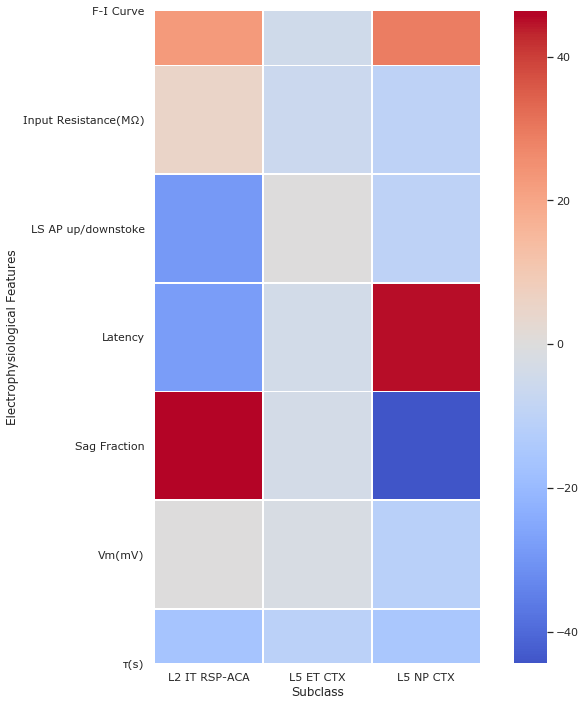

In [18]:
ephys_heatmap(heatmap_df)

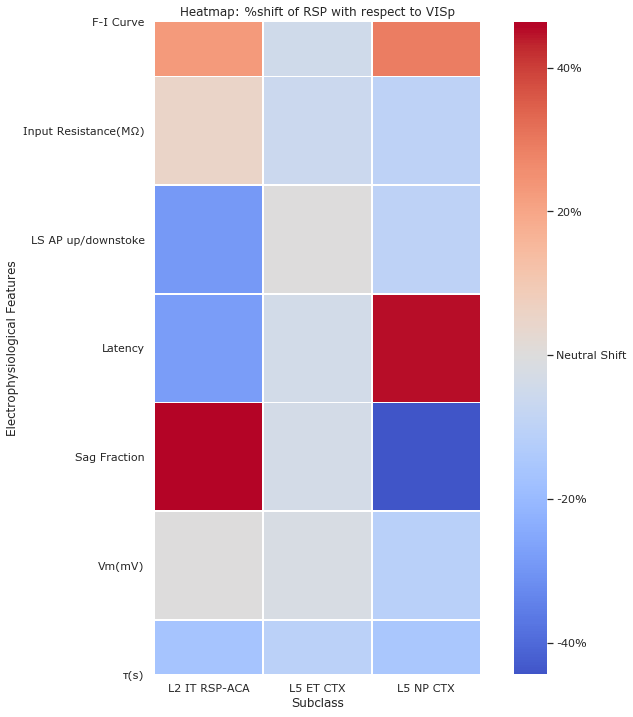

In [20]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data=heatmap_df, cmap="coolwarm", center=0, robust=True,
            linewidths=0.5, square=True, cbar=True, cbar_kws={"shrink": 1})

plt.title("Heatmap: %shift of RSP with respect to VISp")
plt.xlabel("Subclass")
plt.ylabel("Electrophysiological Features")

#Seaborn heatmap cutoffs, so to fix it use the code below
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-55, -40, -20, 0, 20, 40, 55])
cbar.set_ticklabels(["RSP Negative Shift from VISp",
                     "-40%",
                     "-20%", 
                     "Neutral Shift", 
                     "20%", 
                     "40%", 
                     "RSP Positive Shift from VISp"])

plt.savefig(plot_path + "heatmap.jpeg", bbox_inches="tight")